<a href="https://colab.research.google.com/github/noreenanwar/research/blob/master/ACNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!git clone https://github.com/ActiveVisionLab/ANCNet.git

fatal: destination path 'ANCNet' already exists and is not an empty directory.


In [9]:
cd /content/ANCNet

/content/ANCNet


In [4]:
!wget -O ancnet.zip https://www.dropbox.com/s/bjul4f5z7beq3um/ancnet.zip?dl=0 && unzip -q ancnet.zip && rm ancnet.zip

--2022-06-19 05:08:48--  https://www.dropbox.com/s/bjul4f5z7beq3um/ancnet.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bjul4f5z7beq3um/ancnet.zip [following]
--2022-06-19 05:08:48--  https://www.dropbox.com/s/raw/bjul4f5z7beq3um/ancnet.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc55e6f6fed1874d9d56ac579e2c.dl.dropboxusercontent.com/cd/0/inline/BndAB4jGXGnmgP3YQo-_jB8_P60WFDRKKh9WL8vV2bJHlMrRjywTvjjk0UqfwkARn3gBrV35MbxHO2jp8ObC7Q85Vob315pO4ZXyt_U2wDsXS5Z8XzCklZMiry8vGAolClA3MpR21hOTabheVcE1HBXKoCQ4LZS144Uf5HNabfIzsw/file# [following]
--2022-06-19 05:08:49--  https://uc55e6f6fed1874d9d56ac579e2c.dl.dropboxusercontent.com/cd/0/inline/BndAB4jGXGnmgP3YQo-_jB8_P60WFDRKKh9WL8vV2bJHlMrRjywTvjjk0UqfwkARn3gB

In [5]:
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python eval_pf_pascal.py --a 0.1 --num_examples 5

NCNet evaluation script - PF Pascal dataset
Loading checkpoint...
Creating CNN model...
Copying weights...
Done!
args.dataset_image_path datasets/pf-pascal/
100% 299/299 [01:58<00:00,  2.52it/s]
Total: 299
Valid: 299
PCK: 85.86%
visualise correlation
  0% 0/5 [00:01<?, ?it/s]
Traceback (most recent call last):
  File "eval_pf_pascal.py", line 176, in <module>
    main()
  File "eval_pf_pascal.py", line 159, in main
    model, loader_test, batch_tnf, image_size=cnn_image_size, MAX=num_examples
  File "/content/ANCNet/lib/tools.py", line 570, in visualise_feature
    im = cm_hot(keycorrB_A[b, n].detach().cpu()) * 255
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py", line 561, in __call__
    elif np.any(np.isnan(X)):
  File "<__array_function__ internals>", line 6, in any
  File "/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py", line 2359, in any
    keepdims=keepdims, where=where)
  File "/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.

In [10]:
from __future__ import print_function, division
import os
from os.path import exists, join, basename
import numpy as np
import scipy as sc
import scipy.misc
from collections import OrderedDict
import matplotlib.pyplot as plt
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset

from lib.model import ImMatchNet,MutualMatching
from lib.normalization import NormalizeImageDict
from lib.torch_util import save_checkpoint, str_to_bool
from lib.point_tnf import corr_to_matches
from lib.point_tnf import normalize_axis, unnormalize_axis, bilinearInterpPointTnf
from lib.plot import plot_image

# CUDA
use_cuda = torch.cuda.is_available()

In [13]:
checkpoint_path='models/ancnet_86_11.pth.tar'

checkpoint = torch.load(
    checkpoint_path, map_location=lambda storage, loc: storage
)
checkpoint["state_dict"] = OrderedDict(
    [
        (k.replace("vgg", "model"), v)
        for k, v in checkpoint["state_dict"].items()
    ]
)

model = ImMatchNet(
        use_cuda=use_cuda,
        feature_extraction_cnn='resnet101',
        checkpoint=checkpoint,
        ncons_kernel_sizes=[5, 5, 5],
        ncons_channels= [1,16, 16, 1],
        pss=1,
        noniso=3,
    )


model.eval()
model.FeatureExtraction.eval()


for param in model.NeighConsensus.parameters():
    param.requires_grad = False
print('Done')    

Copying weights...
Done!
Done


In [15]:
from lib.pf_dataset import PFPascalDataset
Dataset = PFPascalDataset
csv_file = 'image_pairs/test_pairs.csv'    
eval_dataset_path='datasets/pf-pascal/'
image_size=400
feature_size=int(image_size*0.0625)

dataset = Dataset(csv_file=os.path.join(eval_dataset_path, csv_file),
                  dataset_path=eval_dataset_path,
                  transform=NormalizeImageDict(['source_image','target_image']),
                  output_size=(image_size,image_size))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


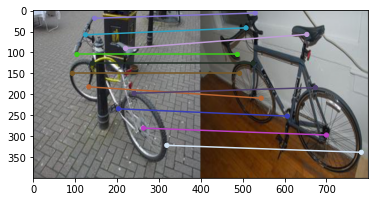

43


In [16]:
# draw sample
idx=np.random.randint(len(dataset))
sample=dataset[idx]
src=sample['source_image']
tgt=sample['target_image']
tgt_pts = Variable(sample['target_points'],requires_grad=False)
src_pts = Variable(sample['source_points'],requires_grad=False)

# ground truth annotations
valid_pts=tgt_pts[0,:]!=-1
tgt_pts=torch.cat((tgt_pts[0,:][valid_pts].view(1,1,-1),tgt_pts[1,:][valid_pts].view(1,1,-1)),1)
tgt_pts[0,0,:]=normalize_axis(tgt_pts[0,0,:],sample['target_im_size'][1])
tgt_pts[0,1,:]=normalize_axis(tgt_pts[0,1,:],sample['target_im_size'][0])

valid_pts=src_pts[0,:]!=-1
src_pts=torch.cat((src_pts[0,:][valid_pts].view(1,1,-1),src_pts[1,:][valid_pts].view(1,1,-1)),1)
src_pts[0,0,:]=normalize_axis(src_pts[0,0,:],sample['source_im_size'][1])
src_pts[0,1,:]=normalize_axis(src_pts[0,1,:],sample['source_im_size'][0])

# evaluate model on image pair
batch_tnf={'source_image':Variable(src.unsqueeze(0)),'target_image':Variable(tgt.unsqueeze(0))}

if use_cuda:
    src_pts = src_pts.cuda()
    tgt_pts = tgt_pts.cuda()
    batch_tnf['source_image']=batch_tnf['source_image'].cuda()
    batch_tnf['target_image']=batch_tnf['target_image'].cuda()
    
corr4d=model(batch_tnf)

# compute matches from output
c2m=corr_to_matches
xA,yA,xB,yB,sB=c2m(corr4d,do_softmax=True)
warped_points = bilinearInterpPointTnf((xA,yA,xB,yB),tgt_pts)

# display result
im=plot_image(torch.cat((batch_tnf['target_image'],batch_tnf['source_image']),3),0,return_im=True)
plt.imshow(im)
tgt_pts[0,0,:] = unnormalize_axis(tgt_pts[0,0,:],tgt.shape[2])
tgt_pts[0,1,:] = unnormalize_axis(tgt_pts[0,1,:],tgt.shape[1])
warped_points[0,0,:] = unnormalize_axis(warped_points[0,0,:],src.shape[2])
warped_points[0,1,:] = unnormalize_axis(warped_points[0,1,:],src.shape[1])

for i in range(tgt_pts.shape[2]):
    xa = float(tgt_pts[0,0,i])
    ya = float(tgt_pts[0,1,i])
    xb = float(warped_points[0,0,i])+tgt.shape[2]
    yb = float(warped_points[0,1,i])
    c=np.random.rand(3)
    plt.gca().add_artist(plt.Circle((xa,ya), radius=5, color=c))
    plt.gca().add_artist(plt.Circle((xb,yb), radius=5, color=c))
    plt.plot([xa, xb], [ya, yb], c=c, linestyle='-', linewidth=1.5)    
    
plt.show()
print(idx)

In [1]:
!pip install torch===1.7.1+cu110 torchvision===0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [12]:
print(torch.__version__)

1.7.1+cu110
